# 3.3 Models

En esta iteración entrenamos los modelos tras gestionar el desbalanceo de los datos sin duplicados.

In [13]:
import pandas as pd

import sys
sys.path.append("..")
from src.support_models import *

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek


In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
parametros_logistic =  [{'penalty': ['l1'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['none'], 'solver': ['lbfgs'], 'max_iter': [10000]}]

parametros_dt = {'max_depth': [4, 10, 14, 25, 40],
            'min_samples_split': [6, 8, 10, 15, 20, 25],
            'min_samples_leaf': [6, 8, 10, 15, 20, 25],
            'max_leaf_nodes': [10, 15, 20, 25, 40, 60, 90, 110]}

parametros_rf = {
            'n_estimators' : [10,20,30,40],
            'max_depth': [5, 10, 15],
            'min_samples_split': [8, 10, 15, 20],
            'min_samples_leaf': [6, 8, 10, 15, 20],
            'max_leaf_nodes': [10, 15, 20, 25]
}

parametros_gb = {
    'n_estimators': [50,100],
    'max_depth': [3,5,7],
    'min_samples_split': [3,4,7],
    'min_samples_leaf': [3,4,7],
    'max_leaf_nodes': [6,10,12]
}

parametros_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
}

parametros_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]}

In [16]:
df = pd.read_pickle("../datos/prepped_nodup.pkl")

In [17]:
categorical_columns = df.drop(columns="Attrition").select_dtypes(include=["object", "category"]).columns
df_encoded = df.copy()

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

X = df_encoded.drop(columns="Attrition")
y = df_encoded["Attrition"]


smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

for col in categorical_columns:
    X_resampled[col] = label_encoders[col].inverse_transform(X_resampled[col])

In [18]:
model_resampled = ClassificationModel(X_resampled, y_resampled)

In [19]:
model_resampled.train(model_type="logistic", scoring="recall", params=parametros_logistic, verbose=1)
model_resampled.train(model_type="decision_tree", scoring="recall", params=parametros_dt, verbose=1)
model_resampled.train(model_type="gradient_boosting", scoring="recall", params=parametros_gb, verbose=1)
model_resampled.train(model_type="xgboost", scoring="recall", params=parametros_xgb, verbose=1)
model_resampled.train(model_type="random_forest", scoring="recall", params=parametros_rf, verbose=1)
model_resampled.train(model_type="svc", scoring="recall", params=parametros_svc, verbose=1)

Fitting 5 folds for each of 43 candidates, totalling 215 fits


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


SVC(C=0.1, degree=2, gamma='auto', kernel='poly', random_state=42)

El modelo 'svc' no soporta la función predict_proba y no se puede graficar la curva ROC.
El modelo 'svc' no soporta la función predict_proba y no se puede graficar la curva ROC.


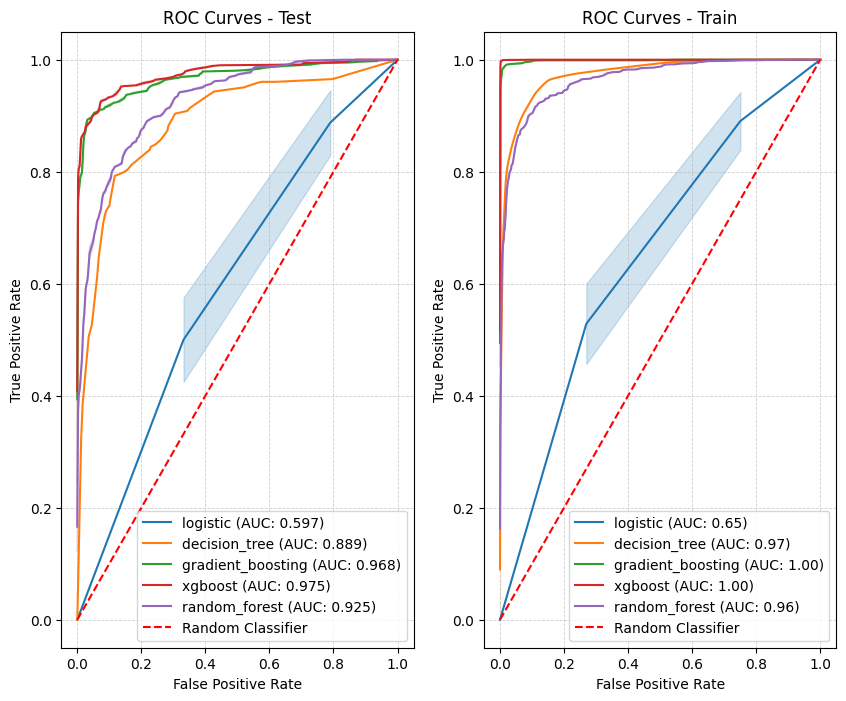

In [20]:
model_resampled.plot_roc_curves()

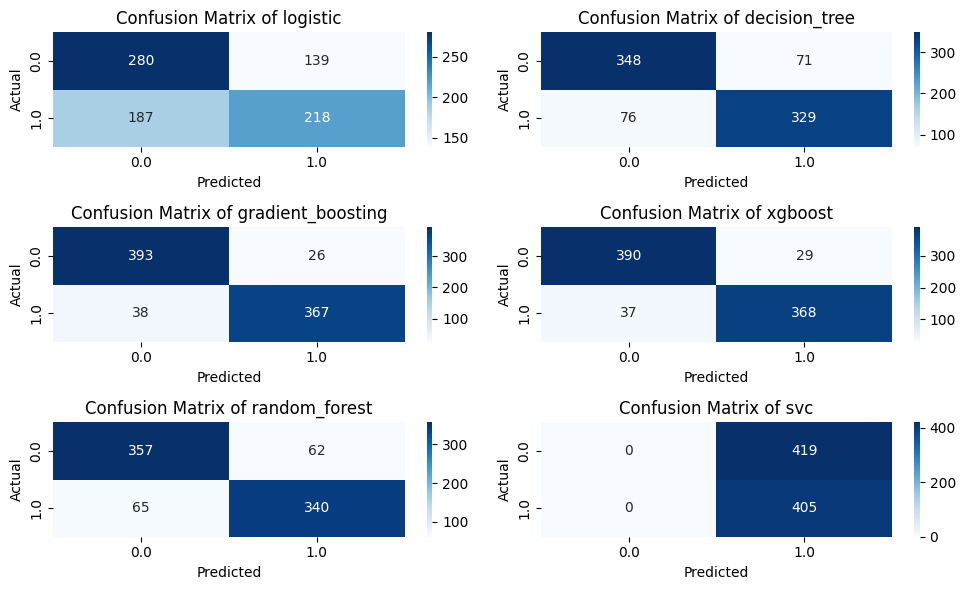

In [21]:
model_resampled.plot_confusion_matrix()

In [22]:
df_metrics_resampled = pd.DataFrame()
for k in model_resampled.resultados.keys():
    df_it = model_resampled.resultados[k]["metrics"]
    df_it["method"] = k
    df_metrics_resampled = pd.concat([df_metrics_resampled, df_it])

df_resultados_colores_resampled = df_metrics_resampled.copy()
df_resultados_colores_resampled.reset_index(inplace = True)
df_resultados_colores_resampled = df_resultados_colores_resampled.style.apply(color_filas_por_modelo, axis=1)
df_resultados_colores_resampled

,index,precision,accuracy,recall,f1_score,kappa,auc,time,n_jobs,method
0,train,0.678348,0.644641,0.559917,0.613469,0.290154,0.649950,0.004017,None,logistic
1,test,0.610644,0.604369,0.538272,0.572178,0.206939,0.596659,0.004017,None,logistic
2,train,0.925026,0.915193,0.904959,0.914883,0.830403,0.973053,0.002016,12,decision_tree
3,test,0.822500,0.821602,0.812346,0.817391,0.643027,0.889089,0.002016,12,decision_tree
4,train,0.994698,0.981790,0.969008,0.981685,0.963585,0.998649,0.011041,12,gradient_boosting
5,test,0.933842,0.922330,0.906173,0.919799,0.844538,0.967960,0.011041,12,gradient_boosting
6,train,0.998958,0.994797,0.990702,0.994813,0.989594,0.999963,0.017348,None,xgboost
7,test,0.926952,0.919903,0.908642,0.917706,0.839707,0.974613,0.017348,None,xgboost
8,train,0.919268,0.901665,0.882231,0.900369,0.803378,0.964800,0.040080,-1,random_forest
9,test,0.845771,0.845874,0.839506,0.842627,0.691620,0.925366,0.040080,-1,random_forest


In [25]:
import pickle
with open('../models/model_resampled.pkl', 'wb') as file:
    pickle.dump(model_resampled.resultados["xgboost"]["mejor_modelo"], file)

In [27]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'EducationField', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'Education_1.0', 'Education_2.0',
       'Education_3.0', 'Education_4.0', 'Education_5.0', 'Gender_Female',
       'Gender_Male', 'JobLevel_1.0', 'JobLevel_2.0', 'JobLevel_3.0',
       'JobLevel_4.0', 'JobLevel_5.0', 'StockOptionLevel_0.0',
       'StockOptionLevel_1.0', 'StockOptionLevel_2.0', 'StockOptionLevel_3.0',
       'PerformanceRating_3.0', 'PerformanceRating_4.0'],
      dtype='object')